# STEP4: Joint regulatory inference
We use [`SCENIC+`](https://www.biorxiv.org/content/10.1101/2022.08.19.504505v1) to infer regulatory relationship, please follow its tutorial at [here](https://scenicplus.readthedocs.io/en/latest/pbmc_multiome_tutorial.html)

> NOTE: This step is very slow (20h) and disk consuming (2TB) in our sever.

> NOTE: You should install package `scenicplus` manually, we not recommend install it in `SLAT` environment. Maybe you need create a new conda environment for it.

In [64]:
%load_ext autoreload
%autoreload 2

#supress warnings
import warnings
import sys
import os
import pyranges as pr
import pandas as pd
from pathlib import Path
import dill
import numpy as np
import pybiomart as pbm
import scanpy as sc
import scenicplus
import matplotlib.pyplot as plt
import seaborn as sns


from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
from pycisTopic.cistopic_class import *
from pycisTopic.pseudobulk_peak_calling import peak_calling
from pycisTopic.iterative_peak_calling import *
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import *
from pycisTopic.topic_binarization import *
from pycisTopic.diff_features import *
from pycistarget.utils import region_names_to_coordinates
from scenicplus.wrappers.run_pycistarget import run_pycistarget
from scenicplus.scenicplus_class import create_SCENICPLUS_object
from scenicplus.wrappers.run_scenicplus import run_scenicplus
from scenicplus.eregulon_enrichment import score_eRegulons
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
from scenicplus.dimensionality_reduction import run_eRegulons_tsne, run_eRegulons_umap
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

from scenicplus.dimensionality_reduction import plot_metadata_given_ax
from scenicplus.dimensionality_reduction import plot_AUC_given_ax,plot_eRegulon
# from scenicplus.plotting.dotplot import heatmap_dotplot
from scenicplus.RSS import *
from scenicplus.plotting.correlation_plot import *
from pycisTopic.diff_features import find_highly_variable_features
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape


warnings.simplefilter(action='ignore', category=FutureWarning)
_stderr = sys.stderr
null = open(os.devnull,'wb')
work_dir = 'scenicplus'
tmp_dir = '/rd1/user/xiacr/tmp/scenicplus' # must be absolute path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import importlib
importlib.reload(sc.pp)
importlib.reload(scenicplus.wrappers)
ray.shutdown()

In [7]:
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=120, frameon=False, figsize=(5, 5), facecolor='white')

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'data')):
    os.makedirs(os.path.join(work_dir, 'data'))
if not os.path.exists(os.path.join(work_dir, 'resource')):
    os.makedirs(os.path.join(work_dir, 'resource'))
if not os.path.exists(os.path.join(work_dir, 'scRNA')):
    os.makedirs(os.path.join(work_dir, 'scRNA'))
if not os.path.exists(os.path.join(work_dir, 'scATAC')):
    os.makedirs(os.path.join(work_dir, 'scATAC'))

# scRNA

In [2]:
adata = sc.read_h5ad(os.path.join(work_dir, 'data/rna_filter.h5ad'))
adata.var_names_make_unique()

In [4]:
# make sure X is count matrix
adata.X = adata.layers['counts']
adata.X[0:5,0:5].todense()

matrix([[ 2.,  7.,  0.,  0.,  0.],
        [ 1., 10.,  0.,  0.,  1.],
        [ 1.,  4.,  2.,  0.,  0.],
        [ 1.,  6.,  3.,  0.,  0.],
        [ 3.,  8.,  2.,  0.,  0.]])

In [5]:
cell_data = adata.obs
cell_data['sample_id'] = 'spatialATAC'
cell_data['celltype'] = cell_data['annotation'].astype(str)
cell_data.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,annotation,Regulon - Aire,leiden,balancing_weight,domain,sample_id,celltype
barcode,,,,,,,,,,,
ATTGAGGAACGCTCGA-1,2378,7.774436,5933,8.688454,Connective tissue,0.000000,13,0.762607,rna,spatialATAC,Connective tissue
AAGACGGAAGAGTCAA-1,2912,7.976939,8378,9.033484,Spinal cord,0.000000,4,0.814203,rna,spatialATAC,Spinal cord
GAATCTGAATCCTGTA-1,1322,7.187657,2469,7.811973,Connective tissue,0.000000,7,1.430239,rna,spatialATAC,Connective tissue
CCGAAGTAGACTAGTA-1,1687,7.431300,4544,8.421783,Head mesenchyme,0.000000,6,0.761644,rna,spatialATAC,Head mesenchyme
CCGAAGTACCAGTTCA-1,3085,8.034631,8691,9.070158,Spinal cord,0.020847,4,0.814203,rna,spatialATAC,Spinal cord


# scATAC

In [70]:
fragments_dict = {'spatialATAC': os.path.join(work_dir, 'data/GSM6043255_ME11_20um_fragments_modify.tsv.gz')}
os.path.isfile(fragments_dict['spatialATAC'])

True

In [65]:
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes'
chromsizes=pd.read_csv(target_url, sep='\t', header=None)
chromsizes.columns=['Chromosome', 'End']
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
# chromsizes = chromsizes.iloc[0:24,:]
chromsizes = pr.PyRanges(chromsizes)

In [71]:
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 8,                                                                                # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = '-')

2022-09-17 16:46:04,455 cisTopic     INFO     Reading fragments from scenicplus/data/GSM6043255_ME11_20um_fragments_modify.tsv.gz


2022-09-17 16:47:36,012	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 


(export_pseudobulk_ray pid=3934210) 2022-09-17 16:47:38,508 cisTopic     INFO     Creating pseudobulk for Brain
(export_pseudobulk_ray pid=3934213) 2022-09-17 16:47:38,958 cisTopic     INFO     Creating pseudobulk for Connectivetissue
(export_pseudobulk_ray pid=3934209) 2022-09-17 16:47:39,118 cisTopic     INFO     Creating pseudobulk for Headmesenchyme
(export_pseudobulk_ray pid=3934215) 2022-09-17 16:47:39,457 cisTopic     INFO     Creating pseudobulk for Heart
(export_pseudobulk_ray pid=3934207) 2022-09-17 16:47:39,991 cisTopic     INFO     Creating pseudobulk for Lungprimordium
(export_pseudobulk_ray pid=3934211) 2022-09-17 16:47:40,192 cisTopic     INFO     Creating pseudobulk for Mesenchyme
(export_pseudobulk_ray pid=3934208) 2022-09-17 16:47:40,801 cisTopic     INFO     Creating pseudobulk for Spinalcord
(export_pseudobulk_ray pid=3934214) 2022-09-17 16:47:41,513 cisTopic     INFO     Creating pseudobulk for Surfaceectoderm
(export_pseudobulk_ray pid=3934214) 2022-09-17 16:47:48

In [72]:
pickle.dump(bed_paths,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [73]:
ray.shutdown()

In [74]:
bed_paths = pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))

macs_path='/rd2/user/xiacr/spatialGLUE/env/scenic/conda/bin/macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=16,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

[mutex.cc : 435] RAW: Lock blocking 0x55f94647ffd0   @
[mutex.cc : 435] RAW: Lock returning 0x55f94647ffd0   @
[mutex.cc : 435] RAW: Unlock 0x55f94647ffd0   @
2022-09-17 16:54:17,557	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 


(macs_call_peak_ray pid=3942725) 2022-09-17 16:54:19,591 cisTopic     INFO     Calling peaks for Mesenchyme with /rd2/user/xiacr/spatialGLUE/env/scenic/conda/bin/macs2 callpeak --treatment scenicplus/scATAC/consensus_peak_calling/pseudobulk_bed_files/Mesenchyme.bed.gz --name Mesenchyme  --outdir scenicplus/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=3942716) 2022-09-17 16:54:19,670 cisTopic     INFO     Calling peaks for Spinalcord with /rd2/user/xiacr/spatialGLUE/env/scenic/conda/bin/macs2 callpeak --treatment scenicplus/scATAC/consensus_peak_calling/pseudobulk_bed_files/Spinalcord.bed.gz --name Spinalcord  --outdir scenicplus/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=3942746) 2022-09-17 16:54:19,708 cisTopic     INFO     C

In [75]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [79]:
# Other param
peak_half_width = 250
path_to_blacklist= os.path.join(work_dir,'data/hg38-blacklist.v2.bed.gz')
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

2022-09-17 17:02:50,010 cisTopic     INFO     Extending and merging peaks per class
2022-09-17 17:03:19,978 cisTopic     INFO     Normalizing peak scores
2022-09-17 17:03:20,121 cisTopic     INFO     Merging peaks
Warning! Start and End columns now have different dtypes: int64 and int32
2022-09-17 17:03:52,909 cisTopic     INFO     Done!


In [80]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

# cisTopic model

In [81]:
import pickle
path_to_regions = {'spatialATAC':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}
# metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb'))
# bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

In [82]:
key = 'spatialATAC'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            # metrics=metadata_bc[key],
                            # valid_bc=list(set(bc_passing_filters[key]) & set(scRNA_bc)),
                            n_cpu=16,
                            project=key,
                            split_pattern='-')
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
print(cistopic_obj)

2022-09-17 17:05:57,345 cisTopic     INFO     Reading data for spatialATAC
2022-09-17 17:06:58,253 cisTopic     INFO     Counting number of unique fragments (Unique_nr_frag)
2022-09-17 17:07:15,810 cisTopic     INFO     Counting fragments in regions


2022-09-17 17:07:19,113	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 


2022-09-17 17:07:29,589 cisTopic     INFO     Creating fragment matrix
2022-09-17 17:07:43,076 cisTopic     INFO     Converting fragment matrix to sparse matrix
2022-09-17 17:07:47,705 cisTopic     INFO     Removing blacklisted regions
2022-09-17 17:07:48,501 cisTopic     INFO     Creating CistopicObject
2022-09-17 17:07:49,161 cisTopic     INFO     Done!
Columns ['sample_id'] will be overwritten
CistopicObject from project spatialATAC with n_cells × n_regions = 2500 × 158399


In [84]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

In [85]:
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,4,10,16,32,48],
                    n_cpu=16,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

2022-09-17 17:08:53,318	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 


(run_cgs_model pid=3961448) 2022-09-17 17:08:55,510 cisTopic     INFO     Running model with 4 topics
(run_cgs_model pid=3961461) 2022-09-17 17:08:55,547 cisTopic     INFO     Running model with 2 topics
(run_cgs_model pid=3961457) 2022-09-17 17:08:55,689 cisTopic     INFO     Running model with 16 topics
(run_cgs_model pid=3961452) 2022-09-17 17:08:55,673 cisTopic     INFO     Running model with 10 topics
(run_cgs_model pid=3961463) 2022-09-17 17:08:55,802 cisTopic     INFO     Running model with 32 topics
(run_cgs_model pid=3961450) 2022-09-17 17:08:55,821 cisTopic     INFO     Running model with 48 topics
(run_cgs_model pid=3961461) 2022-09-17 17:13:37,101 cisTopic     INFO     Model with 2 topics done!
(run_cgs_model pid=3961448) 2022-09-17 17:16:17,972 cisTopic     INFO     Model with 4 topics done!
(run_cgs_model pid=3961452) 2022-09-17 17:23:46,909 cisTopic     INFO     Model with 10 topics done!
(run_cgs_model pid=3961457) 2022-09-17 17:30:50,927 cisTopic     INFO     Model wit

In [86]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir, 'scATAC/models'))

pickle.dump(models,
            open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'wb'))

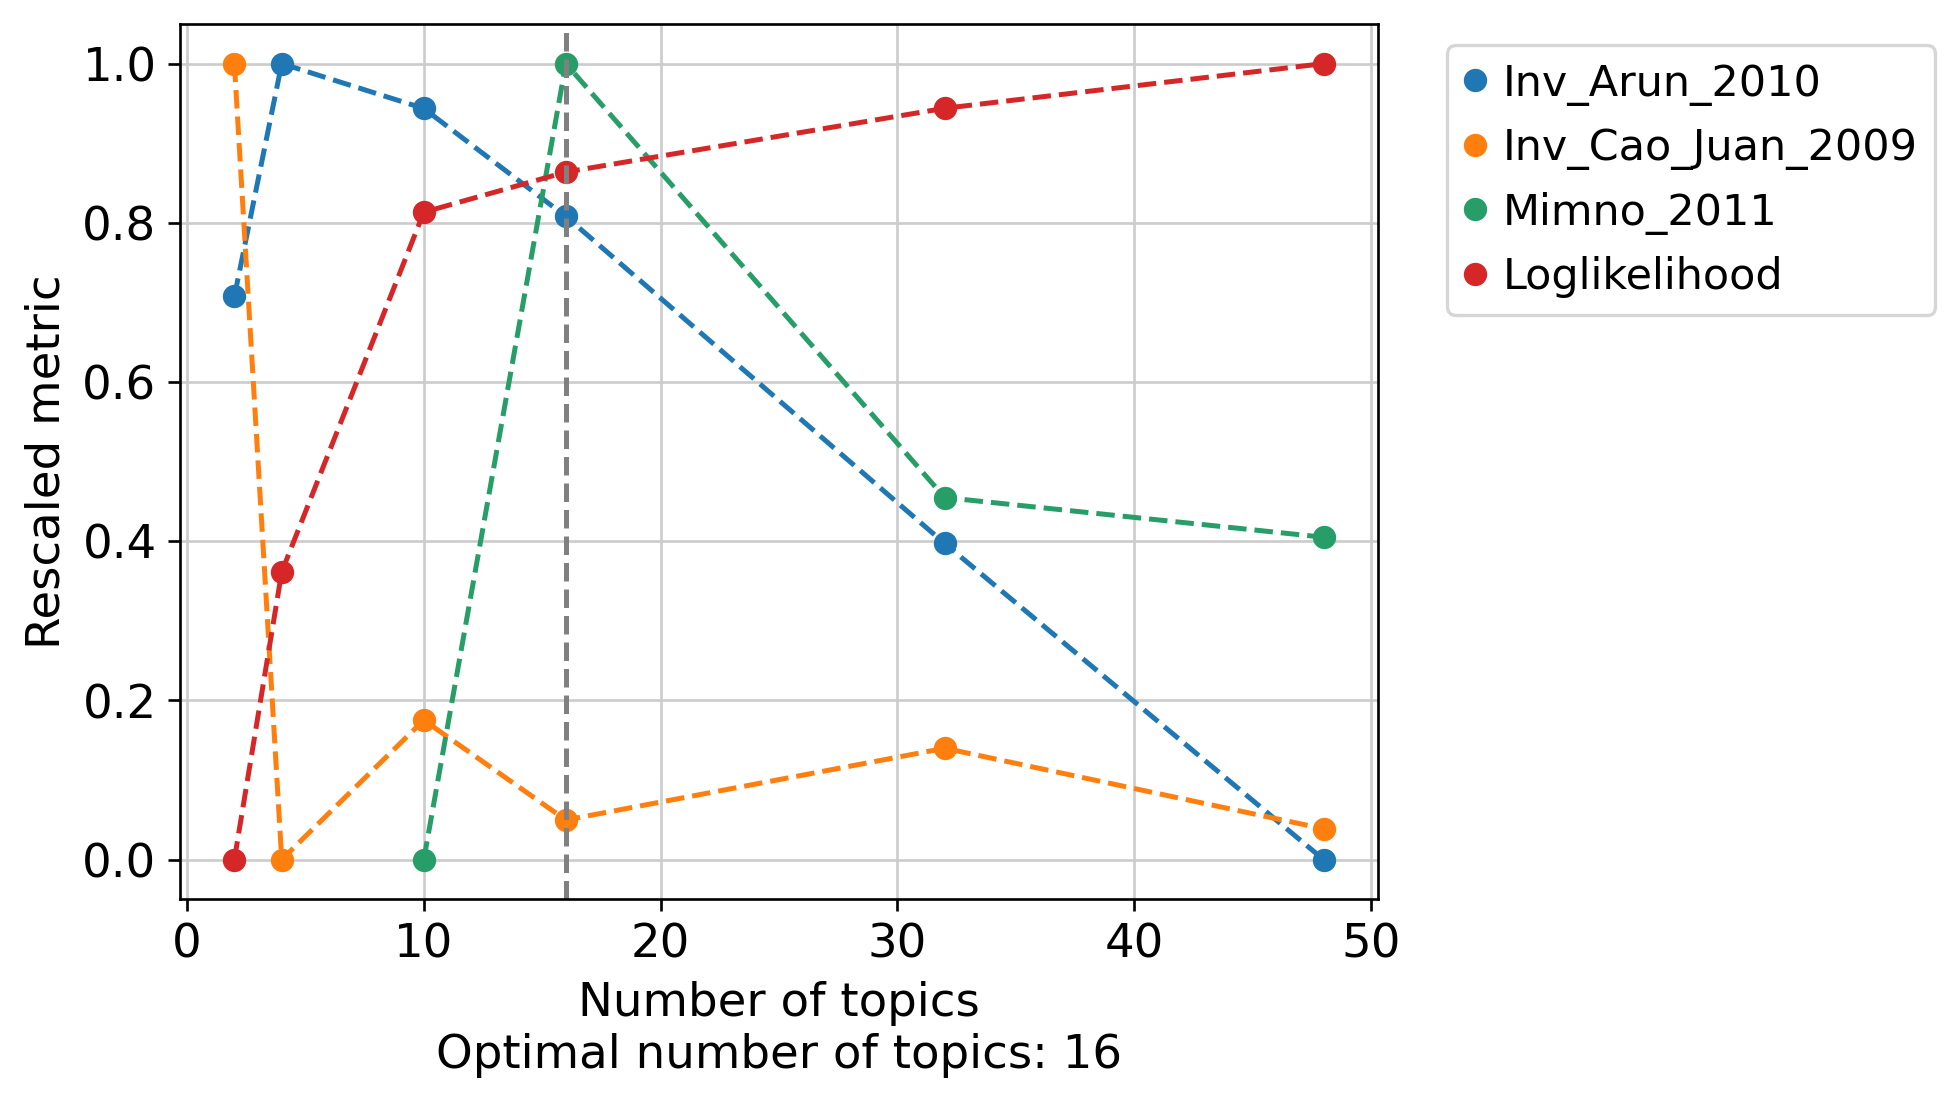

In [87]:
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))

model = evaluate_models(models,
                       select_model=16,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [88]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

# Inferring candidate enhancer regions

In [90]:
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

<Figure size 768x576 with 0 Axes>

<Figure size 768x576 with 0 Axes>

In [164]:
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-', n_cpu=8, log2fc_thr=0.6)

2022-09-18 00:04:26,165 cisTopic     INFO     Imputing drop-outs
2022-09-18 00:04:28,302 cisTopic     INFO     Scaling
2022-09-18 00:04:29,263 cisTopic     INFO     Keep non zero rows
2022-09-18 00:04:30,552 cisTopic     INFO     Imputed accessibility sparsity: 0.005502655951110769
2022-09-18 00:04:30,553 cisTopic     INFO     Create CistopicImputedFeatures object
2022-09-18 00:04:30,554 cisTopic     INFO     Done!
2022-09-18 00:04:30,559 cisTopic     INFO     Normalizing imputed data
2022-09-18 00:04:40,260 cisTopic     INFO     Done!
2022-09-18 00:04:40,278 cisTopic     INFO     Calculating mean
2022-09-18 00:04:40,767 cisTopic     INFO     Calculating variance
2022-09-18 00:04:50,161 cisTopic     INFO     Done!


2022-09-18 00:04:55,891	INFO worker.py:1509 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 


(markers_ray pid=401556) 2022-09-18 00:04:58,128 cisTopic     INFO     Formatting data for Brain
(markers_ray pid=401553) 2022-09-18 00:04:58,432 cisTopic     INFO     Formatting data for Connective tissue
(markers_ray pid=401552) 2022-09-18 00:04:58,672 cisTopic     INFO     Formatting data for Head mesenchyme
(markers_ray pid=401549) 2022-09-18 00:04:58,762 cisTopic     INFO     Formatting data for Heart
(markers_ray pid=401551) 2022-09-18 00:04:59,082 cisTopic     INFO     Formatting data for Lung primordium
(markers_ray pid=401555) 2022-09-18 00:04:59,337 cisTopic     INFO     Formatting data for Mesenchyme
(markers_ray pid=401554) 2022-09-18 00:04:59,402 cisTopic     INFO     Formatting data for Spinal cord
(markers_ray pid=401550) 2022-09-18 00:04:59,865 cisTopic     INFO     Formatting data for Surface ectoderm
(markers_ray pid=401556) 2022-09-18 00:05:01,144 cisTopic     INFO     Computing p-value for Brain
(markers_ray pid=401553) 2022-09-18 00:05:01,879 cisTopic     INFO     

<Figure size 600x600 with 0 Axes>

In [152]:
# markers_dict
# del markers_dict['Surface ectoderm']
# del markers_dict['Head mesenchyme']
# del markers_dict['Mesenchyme']

In [199]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

# DARMotif enrichment analysis using pycistarget

In [200]:
region_sets = {}
region_sets['topics_otsu'] = {}
region_sets['topics_top_3'] = {}
region_sets['DARs'] = {}
for topic in region_bin_topics_otsu.keys():
    regions = region_bin_topics_otsu[topic].index[region_bin_topics_otsu[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_otsu'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for topic in region_bin_topics_top3k.keys():
    regions = region_bin_topics_top3k[topic].index[region_bin_topics_top3k[topic].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['topics_top_3'][topic] = pr.PyRanges(region_names_to_coordinates(regions))
for DAR in markers_dict.keys():
    regions = markers_dict[DAR].index[markers_dict[DAR].index.str.startswith('chr')] #only keep regions on known chromosomes
    region_sets['DARs'][DAR] = pr.PyRanges(region_names_to_coordinates(regions)) if not regions.empty else pr.PyRanges(pd.DataFrame(columns="Chromosome Start End".split()))

In [218]:
del region_sets['topics_otsu']['Topic1']
del region_sets['topics_otsu']['Topic3']
del region_sets['topics_top_3']['Topic1']
del region_sets['topics_top_3']['Topic3']


KeyError: 'Topic1'

In [228]:
del region_sets['DARs']['Surface ectoderm']
del region_sets['DARs']['Head mesenchyme']
del region_sets['DARs']['Mesenchyme']

In [229]:
for key in region_sets.keys():
    print(f'{key}: {region_sets[key].keys()}')

topics_otsu: dict_keys(['Topic2', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
topics_top_3: dict_keys(['Topic2', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Topic16'])
DARs: dict_keys(['Brain', 'Connective tissue', 'Heart', 'Lung primordium', 'Spinal cord'])


In [230]:
db_fpath = "scenicplus/resource/"
rankings_db = os.path.join(db_fpath, 'mm10_screen_v10_clust.regions_vs_motifs.rankings.feather')
scores_db =  os.path.join(db_fpath, 'mm10_screen_v10_clust.regions_vs_motifs.scores.feather')
motif_annotation = os.path.join(db_fpath, 'motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl')

In [172]:
f1 = pr.from_dict({'Chromosome': ['chr1', 'chr1', 'chr1'], 'Start': [3, 8, 5], 'End': [6, 9, 7], 'Name': ['interval1', 'interval3', 'interval2']})
f2 = pr.from_dict({'Chromosome': ['chr1', 'chr1'], 'Start': [1, 6], 'End': [2, 7], 'Name': ['a', 'b']})
f3= f1.join(f2,report_overlap=True)

In [196]:
f3.b = 100
f3

,Chromosome,Start,End,Name,Start_b,End_b,Name_b,Overlap,a,b
0,chr1,5,7,interval2,6,7,b,1,100,100


In [206]:
pd.DataFrame([], index=['Target', 'Query']).T

,Target,Query


In [233]:
if not os.path.exists(os.path.join(work_dir, 'motifs')):
    os.makedirs(os.path.join(work_dir, 'motifs'))
run_pycistarget(
    region_sets = region_sets,
    species = 'mus_musculus',
    save_path = os.path.join(work_dir, 'motifs'),
    ctx_db_path = rankings_db,
    dem_db_path = scores_db,
    path_to_motif_annotations = motif_annotation,
    run_without_promoters = True,
    n_cpu = 24,
    _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
    annotation_version = 'v10nr_clust',
    )

2022-09-18 03:51:07,645 pycisTarget_wrapper INFO     scenicplus/motifs folder already exists.
2022-09-18 03:51:08,013 pycisTarget_wrapper INFO     Loading cisTarget database for topics_otsu
2022-09-18 03:51:08,015 cisTarget    INFO     Reading cisTarget database
2022-09-18 03:52:06,539 pycisTarget_wrapper INFO     Running cisTarget for topics_otsu
(ctx_internal_ray pid=642773) 2022-09-18 03:52:15,499 cisTarget    INFO     Running cisTarget for Topic2 which has 7995 regions
(ctx_internal_ray pid=642784) 2022-09-18 03:52:15,888 cisTarget    INFO     Running cisTarget for Topic4 which has 6910 regions
(ctx_internal_ray pid=642751) 2022-09-18 03:52:16,301 cisTarget    INFO     Running cisTarget for Topic5 which has 5803 regions
(ctx_internal_ray pid=642750) 2022-09-18 03:52:16,674 cisTarget    INFO     Running cisTarget for Topic6 which has 6600 regions
(ctx_internal_ray pid=642779) 2022-09-18 03:52:16,974 cisTarget    INFO     Running cisTarget for Topic7 which has 7957 regions
(ctx_inter

In [4]:
menr = dill.load(open(os.path.join(work_dir, 'motifs/menr.pkl'), 'rb'))
menr['DEM_topics_otsu_All'].DEM_results('Topic5')

,Logo,Contrast,Direct_annot,Orthology_annot,Log2FC,Adjusted_pval,Mean_fg,Mean_bg,Motif_hit_thr,Motif_hits
jaspar__MA1962.1,,Topic5,NaN,Sox2,2.193371,0.014184,0.348352,0.076164,3.0,243.0
tfdimers__MD00591,,Topic5,NaN,"Tfap2c, Sry",1.598976,0.0,0.734453,0.242451,3.0,501.0
tfdimers__MD00533,,Topic5,NaN,"Pbx1, Pou2f1",1.485354,0.03565,0.441896,0.157828,3.0,297.0
tfdimers__MD00293,,Topic5,NaN,"Sox4, Smad1",1.382805,0.000513,0.557154,0.213653,3.0,405.0
tfdimers__MD00034,,Topic5,NaN,"Pdx1, Sox2",1.378751,0.035395,0.352638,0.135607,3.0,245.0
taipale_tf_pairs__POU2F1_SOX2_ATTTGCATNACAATRN_CAP,,Topic5,NaN,"Pou2f1, Sox2",1.341223,0.000029,0.616952,0.243502,3.0,423.0
swissregulon__hs__SOX9,,Topic5,NaN,Sox9,1.324517,0.0,1.078976,0.430816,3.0,807.0
homer__VVRRAACAATGG_Sox7,,Topic5,Sox7,NaN,1.26983,0.0,1.517041,0.62913,3.0,1164.0
tfdimers__MD00402,,Topic5,NaN,"Pax4, Pou2f2",1.241641,0.016755,0.423095,0.178923,3.0,295.0
taipale_tf_pairs__CUX1_SOX15_NATCRATNNNNNNNNAACAATRS_CAP_repr,,Topic5,NaN,"Sox15, Cux1",1.226302,0.003264,0.26223,0.11208,3.0,116.0


# inferring enhancer-driven Gene Regulatory Networks (eGRNs) using SCENIC+

In [3]:
cistopic_obj = dill.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))

In [7]:
cistopic_obj.cell_names

['CCGAAGTACTGTAGCC-1-spatialATAC',
 'AGAGTCAACGCATACA-1-spatialATAC',
 'ACCTCCAACCGTGAGA-1-spatialATAC',
 'AAGACGGACATCAAGT-1-spatialATAC',
 'CGCATACACCAGTTCA-1-spatialATAC',
 'CTGAGCCAGAGCTGAA-1-spatialATAC',
 'CAAGACTAACATTGGC-1-spatialATAC',
 'AACGCTTAACTATGCA-1-spatialATAC',
 'CGACTGGAACAAGCTA-1-spatialATAC',
 'ACCTCCAACACTTCGA-1-spatialATAC',
 'AACGTGATAGCAGGAA-1-spatialATAC',
 'CTGTAGCCAACCGAGA-1-spatialATAC',
 'CATCAAGTCGAACTTA-1-spatialATAC',
 'ACAAGCTACAGCGTTA-1-spatialATAC',
 'AAGACGGAAGTCACTA-1-spatialATAC',
 'AACGCTTAAACCGAGA-1-spatialATAC',
 'CAGCGTTACAAGACTA-1-spatialATAC',
 'AAGGTACAATCCTGTA-1-spatialATAC',
 'ACGTATCACAGCGTTA-1-spatialATAC',
 'AGAGTCAACCGAAGTA-1-spatialATAC',
 'CGCTGATCAGAGTCAA-1-spatialATAC',
 'ACAGCAGACCTCCTGA-1-spatialATAC',
 'CACTTCGAAAGACGGA-1-spatialATAC',
 'CCAGTTCACGCATACA-1-spatialATAC',
 'AGTCACTAAGATCGCA-1-spatialATAC',
 'ATTGAGGAACGCTCGA-1-spatialATAC',
 'GACTAGTACCGTGAGA-1-spatialATAC',
 'AAGACGGAAGAGTCAA-1-spatialATAC',
 'GAATCTGAATCCTGTA-1

In [5]:
scplus_obj = create_SCENICPLUS_object(
    GEX_anndata = adata,
    cisTopic_obj = cistopic_obj,
    menr = menr,
    bc_transform_func = lambda x: f'{x}-spatialATAC' #function to convert scATAC-seq barcodes to scRNA-seq ones
)
# scplus_obj.X_EXP = np.array(scplus_obj.X_EXP) # already in np.array format
scplus_obj

2022-09-18 14:54:22,272 cisTopic     INFO     Imputing drop-outs
2022-09-18 14:54:23,412 cisTopic     INFO     Scaling
2022-09-18 14:54:24,377 cisTopic     INFO     Keep non zero rows
2022-09-18 14:54:25,362 cisTopic     INFO     Imputed accessibility sparsity: 0.006690130317124399
2022-09-18 14:54:25,364 cisTopic     INFO     Create CistopicImputedFeatures object
2022-09-18 14:54:25,365 cisTopic     INFO     Done!


SCENIC+ object with n_cells x n_genes = 1879 x 24365 and n_cells x n_regions = 1879 x 158399
	metadata_regions:'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc'
	metadata_genes:'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag'
	metadata_cell:'GEX_n_genes_by_counts', 'GEX_log1p_n_genes_by_counts', 'GEX_total_counts', 'GEX_log1p_total_counts', 'GEX_annotation', 'GEX_Regulon - Aire', 'GEX_leiden', 'GEX_balancing_weight', 'GEX_domain', 'ACC_cisTopic_nr_frag', 'ACC_barcode', 'ACC_Unique_nr_frag', 'ACC_cisTopic_log_nr_frag', 'ACC_cisTopic_nr_acc', 'ACC_cisTopic_log_nr_acc

In [ ]:
# Optional: default use 105, the latest version of gene symbol, and this cell can run very slow due to bad network
# ensembl_version_dict = {'105': 'http://www.ensembl.org',
#                         '104': 'http://may2021.archive.ensembl.org/',
#                         '103': 'http://feb2021.archive.ensembl.org/',
#                         '102': 'http://nov2020.archive.ensembl.org/',
#                         '101': 'http://aug2020.archive.ensembl.org/',
#                         '100': 'http://apr2020.archive.ensembl.org/',
#                         '99': 'http://jan2020.archive.ensembl.org/',
#                         '98': 'http://sep2019.archive.ensembl.org/',
#                         '97': 'http://jul2019.archive.ensembl.org/',
#                         '96': 'http://apr2019.archive.ensembl.org/',
#                         '95': 'http://jan2019.archive.ensembl.org/',
#                         '94': 'http://oct2018.archive.ensembl.org/',
#                         '93': 'http://jul2018.archive.ensembl.org/',
#                         '92': 'http://apr2018.archive.ensembl.org/',
#                         '91': 'http://dec2017.archive.ensembl.org/',
#                         '90': 'http://aug2017.archive.ensembl.org/',
#                         '89': 'http://may2017.archive.ensembl.org/',
#                         '88': 'http://mar2017.archive.ensembl.org/',
#                         '87': 'http://dec2016.archive.ensembl.org/',
#                         '86': 'http://oct2016.archive.ensembl.org/',
#                         '80': 'http://may2015.archive.ensembl.org/',
#                         '77': 'http://oct2014.archive.ensembl.org/',
#                         '75': 'http://feb2014.archive.ensembl.org/',
#                         '54': 'http://may2009.archive.ensembl.org/'}


# def test_ensembl_host(scplus_obj, host, species):
#     dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
#     annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
#     annot.columns = ['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
#     annot['Chromosome'] = annot['Chromosome'].astype('str')
#     filter = annot['Chromosome'].str.contains('CHR|GL|JH|MT')
#     annot = annot[~filter]
#     annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
#     gene_names_release = set(annot['Gene'].tolist())
#     ov=len([x for x in scplus_obj.gene_names if x in gene_names_release])
#     print('Genes recovered: ' + str(ov) + ' out of ' + str(len(scplus_obj.gene_names)))
#     return ov

# n_overlap = {}
# for version in ensembl_version_dict.keys():
#     print(f'host: {version}')
#     try:
#         n_overlap[version] =  test_ensembl_host(scplus_obj, ensembl_version_dict[version], 'mmusculus')
#     except:
#         print('Host not reachable')
# v = sorted(n_overlap.items(), key=lambda item: item[1], reverse=True)[0][0]
# print(f"version: {v} has the largest overlap, use {ensembl_version_dict[v]} as biomart host")

host: 105


/rd2/user/xiacr/spatialGLUE/env/scenic/conda/lib/python3.8/site-packages/pybiomart/dataset.py:269: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(StringIO(response.text), sep='\t')


Genes recovered: 24352 out of 24365
host: 104


/rd2/user/xiacr/spatialGLUE/env/scenic/conda/lib/python3.8/site-packages/pybiomart/dataset.py:269: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = pd.read_csv(StringIO(response.text), sep='\t')


Genes recovered: 24339 out of 24365
host: 103
Genes recovered: 24338 out of 24365
host: 102
Genes recovered: 24345 out of 24365
host: 101
Host not reachable
host: 100
Host not reachable
host: 99
Genes recovered: 24345 out of 24365
host: 98
Genes recovered: 24343 out of 24365
host: 97
Genes recovered: 24349 out of 24365
host: 96
Genes recovered: 24350 out of 24365
host: 95
Host not reachable
host: 94
Host not reachable
host: 93


In [9]:
!wget -O scenicplus/data/allTFs_mm.txt  https://resources.aertslab.org/cistarget/tf_lists/allTFs_mm.txt
# !wget -O scenicplus/bedToBigBed http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bedToBigBed
# !chmod +x scenicplus/bedToBigBed

--2022-09-18 20:24:09--  https://resources.aertslab.org/cistarget/tf_lists/allTFs_mm.txt
Resolving resources.aertslab.org (resources.aertslab.org)... 2a02:2c40:0:80::80:1284, 134.58.65.132
Connecting to resources.aertslab.org (resources.aertslab.org)|2a02:2c40:0:80::80:1284|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11726 (11K) [text/plain]
Saving to: ‘scenicplus/data/allTFs_mm.txt’

scenicplus/data/all 100%[===================>]  11.45K  --.-KB/s    in 0s      

2022-09-18 20:24:11 (107 MB/s) - ‘scenicplus/data/allTFs_mm.txt’ saved [11726/11726]



In [6]:
#only keep the first two columns of the PCA embedding in order to be able to visualize this in SCope
scplus_obj.dr_cell['GEX_X_pca'] = scplus_obj.dr_cell['GEX_X_pca'].iloc[:, 0:2]
# scplus_obj.dr_cell['GEX_rep'] = scplus_obj.dr_cell['GEX_rep'].iloc[:, 0:2]

In [26]:
pd.DataFrame(index=adata.var_names)

""
gene_short_name
4930481A15Rik
Adgrd1
Angel1
Ankrd27
Anp32a
...
Gm48969
Gm6408
Gm32052


In [43]:
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
try:
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['GEX_annotation'],
        species = 'mmusculus',
        assembly = 'mm10',
        tf_file = 'scenicplus/data/allTFs_mm.txt',
        save_path = os.path.join(work_dir, 'scenicplus'),
        biomart_host = "http://www.ensembl.org",
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = True,
        calculate_DEGs_DARs = False,
        export_to_loom_file = False,
        export_to_UCSC_file = False,
        path_bedToBigBed = 'scenicplus',
        n_cpu = 24,
        _temp_dir = os.path.join(tmp_dir, 'ray_spill'))
except Exception as e:
    #in case of failure, still save the object
    dill.dump(scplus_obj, open(os.path.join(work_dir, 'scenicplus/scplus_obj.pkl'), 'wb'), protocol=-1)
    raise(e)

2022-09-19 11:10:03,477 SCENIC+_wrapper INFO     scenicplus/scenicplus folder already exists.
2022-09-19 11:10:03,479 SCENIC+_wrapper INFO     Calculating TF-eGRNs AUC correlation
2022-09-19 11:10:20,625 SCENIC+_wrapper INFO     Saving object
2022-09-19 11:14:53,744 SCENIC+_wrapper INFO     Finished! Took 4.837769571940104 minutes


# Downsteam analysis

In [52]:
apply_std_filtering_to_eRegulons(scplus_obj)

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


In [101]:
region_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(work_dir, 'scenicplus/gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.3,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.3,
                normalize= False,
                n_cpu = 5)

In [91]:
run_eRegulons_umap(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_UMAP', #overwrite previously calculated UMAP
)
run_eRegulons_tsne(
    scplus_obj = scplus_obj,
    auc_key = 'eRegulon_AUC_filtered',
    reduction_name = 'eRegulons_tSNE', #overwrite previously calculated tSNE
)

In [92]:
scplus_obj.metadata_cell.GEX_annotation.value_counts()

Brain                498
Spinal cord          443
Heart                343
Connective tissue    330
Head mesenchyme      128
Mesenchyme           105
Lung primordium       20
Surface ectoderm      12
Name: GEX_annotation, dtype: int64

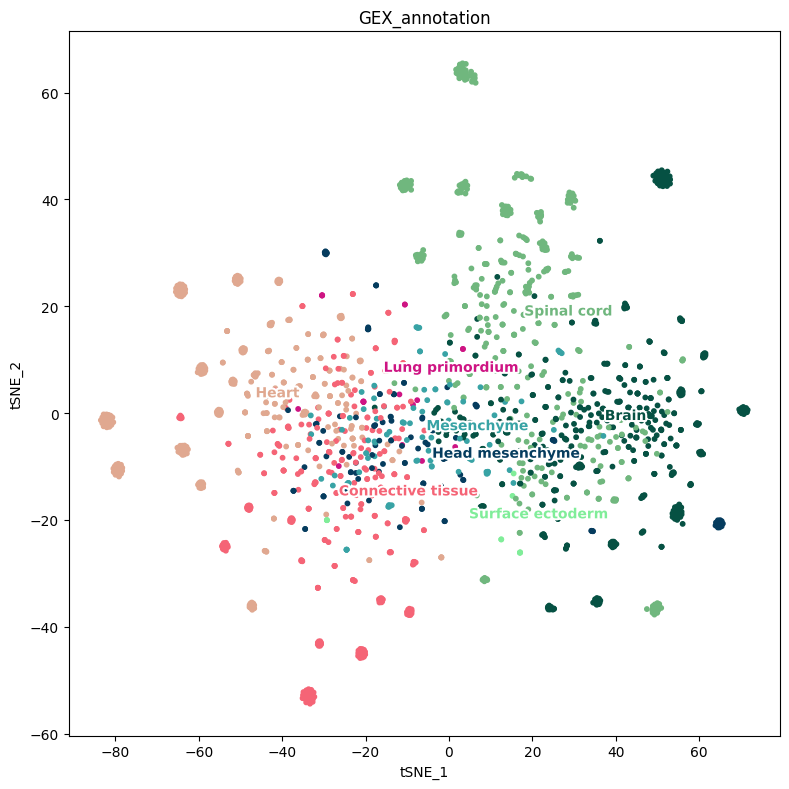

In [102]:
color_dict = {
    'Brain': "#065143",
    'Spinal cord': "#70B77E",
    'Heart': "#E0A890",
    'Connective tissue': "#F56476",
    'Lung primordium': "#CE1483",
    'Head mesenchyme': "#053C5E" ,
    'Mesenchyme': "#38A3A5",
    'Surface ectoderm': "#80ED99"
}
fig, axs = plt.subplots(ncols=1, figsize = (8, 8))
plot_metadata_given_ax(
    scplus_obj=scplus_obj,
    ax = axs,
    reduction_name = 'eRegulons_tSNE',
    variable = 'GEX_annotation', #note the GEX_ prefix, this metadata originated from the gene expression metadata (on which we did the cell type annotation before)
    color_dictionary={'GEX_annotation': color_dict}
)
plt.show()

In [103]:
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'GEX_annotation',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'GEX_annotation',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'GEX_annotation',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'GEX_annotation',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

In [104]:
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.05, 0.05],
        'n_targets': 0
}

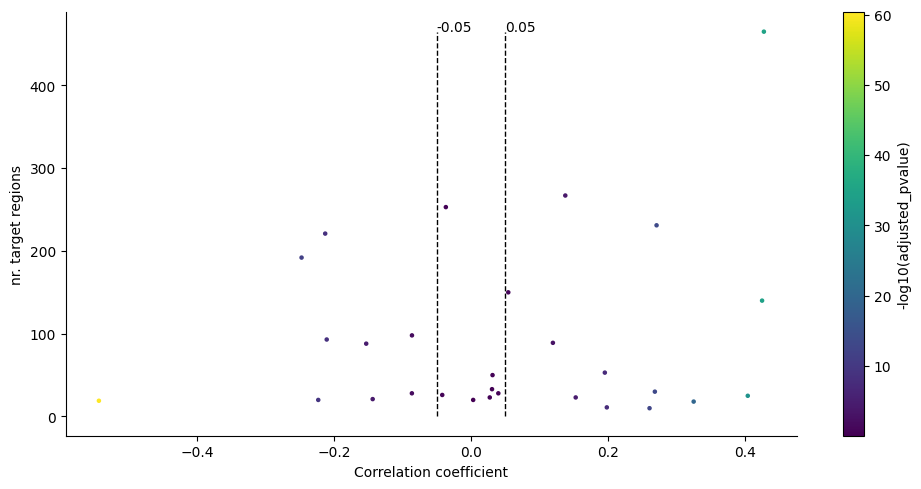

In [105]:
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [106]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 22 eRegulons


In [107]:
regulon_specificity_scores(
        scplus_obj,
        variable = 'GEX_annotation',
        auc_key = 'eRegulon_AUC_filtered',
        signature_keys = ['Region_based'],
        selected_regulons = [x for x in scplus_obj.uns['selected_eRegulon']['Region_based'] if '-' not in x],
        out_key_suffix = '_filtered')

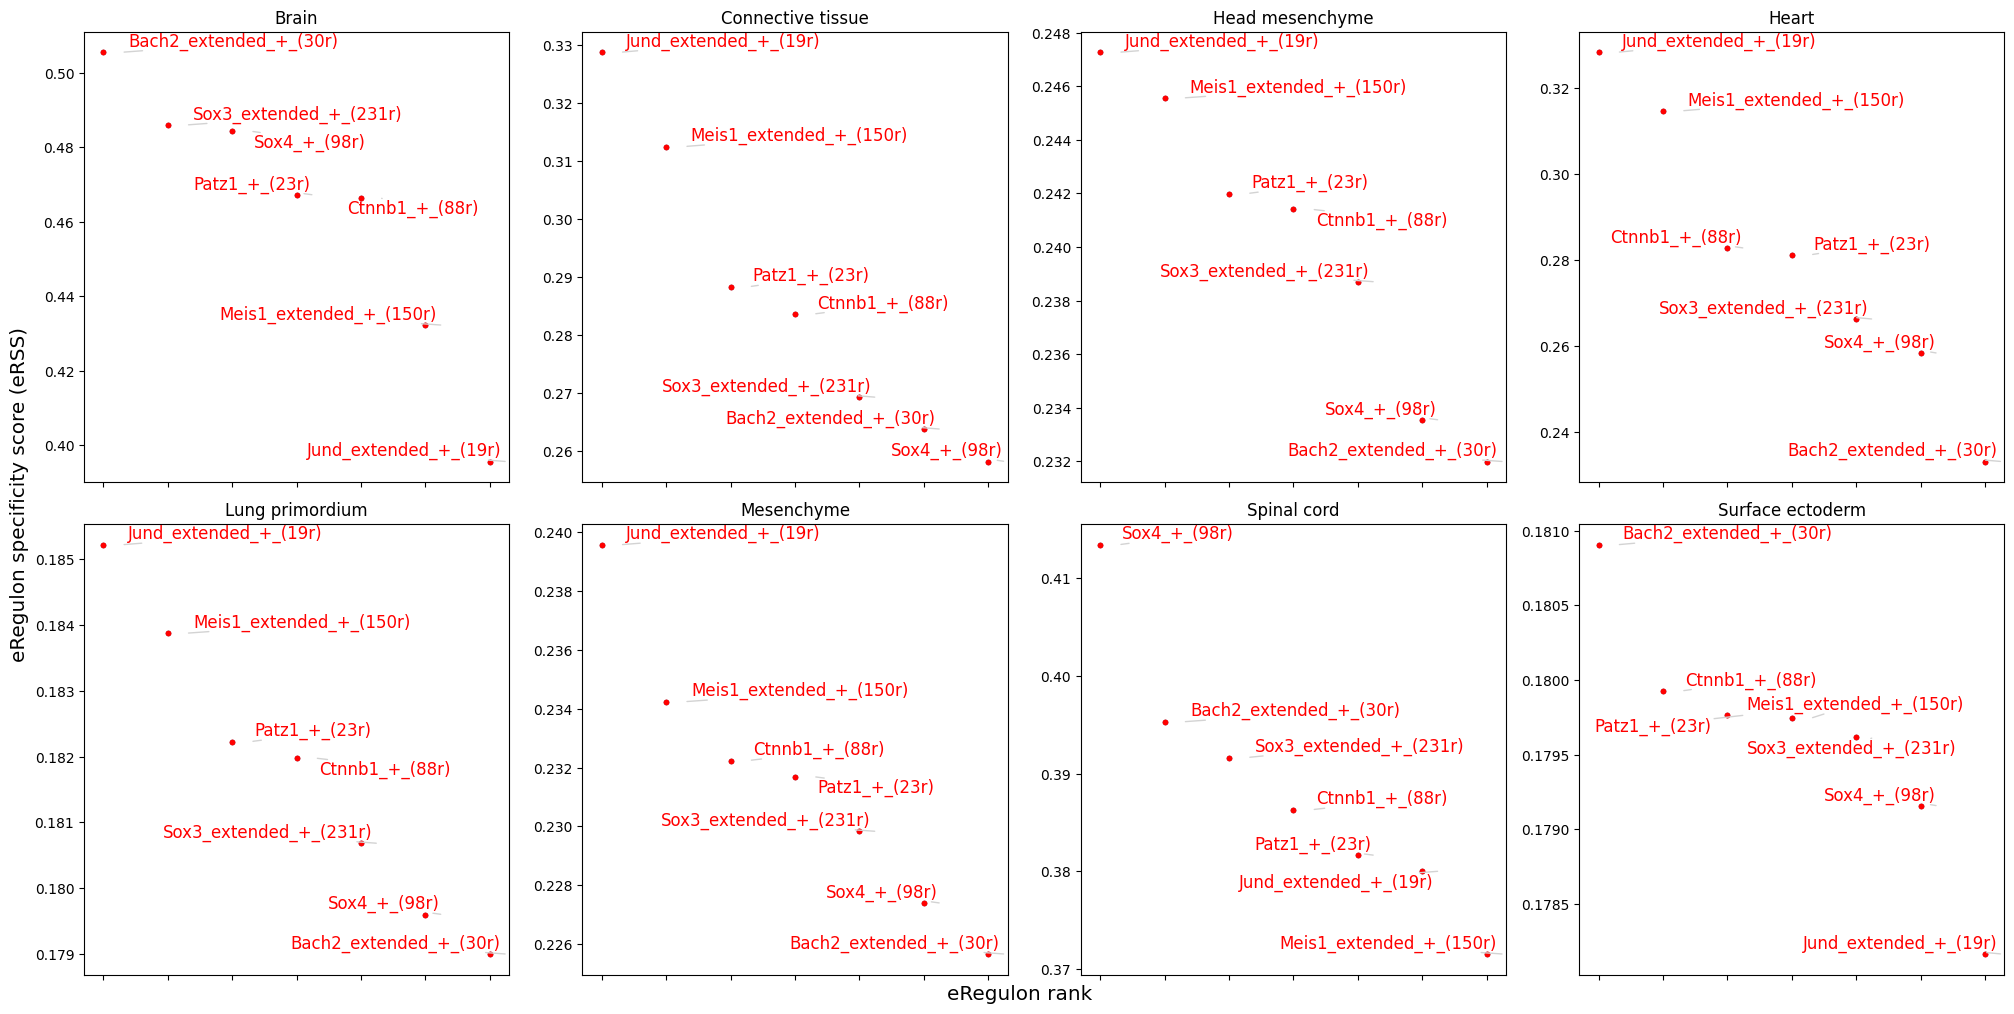

In [108]:
plot_rss(scplus_obj, 'GEX_annotation_filtered', num_columns=4, top_n=10, figsize = (20, 10))

In [109]:
hvr = find_highly_variable_features(scplus_obj.to_df('ACC').loc[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Region']))], n_top_features=1000, plot = False)
hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Gene']))].T, n_top_features=1000, plot = False)

2022-09-19 13:01:47,858 cisTopic     INFO     Calculating mean
2022-09-19 13:01:47,867 cisTopic     INFO     Calculating variance
2022-09-19 13:01:48,037 cisTopic     INFO     Done!
2022-09-19 13:01:48,091 cisTopic     INFO     Calculating mean
2022-09-19 13:01:48,096 cisTopic     INFO     Calculating variance
2022-09-19 13:01:48,189 cisTopic     INFO     Done!


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [124]:
from scenicplus.networks import create_nx_tables, create_nx_graph, plot_networkx, export_to_cytoscape
nx_tables = create_nx_tables(
    scplus_obj = scplus_obj,
    eRegulon_metadata_key ='eRegulon_metadata_filtered',
    subset_eRegulons = ['Jund', 'Meis1', 'Sox3'],
    subset_regions = hvr,
    subset_genes = hvg,
    add_differential_gene_expression = True,
    add_differential_region_accessibility = True,
    differential_variable = ['GEX_annotation'])

... storing 'GEX_annotation' as categorical
... storing 'GEX_annotation' as categorical
... storing 'GEX_annotation' as categorical


In [119]:
nx_tables['Node']

{'TF':       Node_type     TF  GEX_annotation_Log2FC_Brain  \
 Meis1        TF  Meis1                          NaN   
 
        GEX_annotation_Log2FC_Connective tissue  \
 Meis1                                      NaN   
 
        GEX_annotation_Log2FC_Head mesenchyme  GEX_annotation_Log2FC_Heart  \
 Meis1                                    NaN                          NaN   
 
        GEX_annotation_Log2FC_Lung primordium  \
 Meis1                                    NaN   
 
        GEX_annotation_Log2FC_Mesenchyme  GEX_annotation_Log2FC_Spinal cord  \
 Meis1                               NaN                                NaN   
 
        GEX_annotation_Log2FC_Surface ectoderm  
 Meis1                                     NaN  ,
 'Gene':         Node_type     Gene  GEX_annotation_Log2FC_Brain  \
 Topbp1       Gene   Topbp1                          NaN   
 Higd1a       Gene   Higd1a                          NaN   
 Coro1c       Gene   Coro1c                          NaN   
 Ash2l     